# **Hospital Funnel Analysis**

# 1️⃣ Project Objective

* Problem Statement: Many patients inquire but do not convert to admission or treatment, causing lost revenue.
* Goal: Analyze the patient inquiry-to-admission funnel, identify drop-off reasons, and suggest strategies to increase conversion by ~30%.

* Outputs expected:

       Funnel visualizations (Inquiry → Consultation → Admission)

       Drop-off analysis (why patients didn’t convert)

       Insights & recommendations for hospital management


* Optional: Risk scoring for patients likely to drop out

| Column Name          | Data Type   | Description / Meaning                                                           | Example Values                                                 |
| -------------------- | ----------- | ------------------------------------------------------------------------------- | -------------------------------------------------------------- |
| `patient_id`         | String      | Unique identifier for each patient inquiry                                      | P0001, P0123                                                   |
| `inquiry_date`       | Date        | Date when the patient made an inquiry                                           | 2024-04-12, 2025-01-18                                         |
| `inquiry_channel`    | Categorical | How the patient contacted the hospital                                          | Walk-in, Phone, Website, Email, Social Media                   |
| `disease_type`       | Categorical | Medical department or disease category for which the patient inquired           | Pediatrics, Cardiology, Orthopedics                            |
| `doctor_assigned`    | Categorical | Doctor assigned to handle the inquiry or consultation                           | Dr. A Sharma, Dr. R Mehta                                      |
| `consultation_date`  | Date        | Date when consultation was scheduled or happened                                | 2024-04-14, 2025-01-20                                         |
| `admission_advised`  | Categorical | Whether the doctor advised admission after consultation                         | Yes, No                                                        |
| `admitted`           | Categorical | Whether the patient actually got admitted                                       | Yes, No                                                        |
| `admission_date`     | Date        | Date of patient admission if admitted                                           | 2024-04-16, 2025-01-22                                         |
| `reason_for_dropout` | Categorical | Reason for not converting to admission or treatment                             | Cost concerns, Chose other hospital, No response after inquiry |
| `followup_attempts`  | Numeric     | Number of follow-ups done by hospital staff before patient conversion / dropout | 0, 1, 2, 3                                                     |
| `response_time_days` | Numeric     | Number of days hospital took to respond to the patient inquiry                  | 0, 1, 2, 5                                                     |
| `city`               | Categorical | City of the patient                                                             | Mumbai, Thane, Nashik                                          |
| `age`                | Numeric     | Age of the patient in years                                                     | 25, 42, 60                                                     |
| `gender`             | Categorical | Patient gender                                                                  | Male, Female, Other                                            |
| `insurance`          | Categorical | Whether patient has health insurance                                            | Yes, No                                                        |
| `referral_source`    | Categorical | Source that referred or brought the patient                                     | Google, Facebook, Insurance Portal, Doctor Referral            |
| `conversion_score`   | Numeric     | Probability score (0-1) indicating likelihood of patient conversion             | 0.25, 0.73, 0.91                                               |


Key points:

* Funnel stages: Inquiry → Consultation → Admission

* reason_for_dropout helps identify major drop-off causes

* Demographics, channel, doctor, insurance, and response/follow-ups affect conversion

###  **Require Liabraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

### **Data collection**

In [ ]:

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Hospital Project/

Mounted at /gdrive
/gdrive/My Drive/Hospital Project


In [ ]:
## 1️⃣ Load Data
df = pd.read_csv('patient_funnel_1000.csv')
df.head()

,patient_id,inquiry_date,inquiry_channel,disease_type,doctor_assigned,consultation_date,admission_advised,admitted,admission_date,reason_for_dropout,followup_attempts,response_time_days,city,age,gender,insurance,referral_source,conversion_score
0,P0001,2024-04-24,Walk-in,Oncology,Dr. P Joshi,2024-04-24,No,No,NaN,No admission advised (outpatient),0,4,Thane,68,Male,Yes,Community Health Camp,0.087
1,P0002,2024-01-31,Walk-in,Orthopedics,Dr. V Singh,2024-02-01,No,No,NaN,No admission advised (outpatient),0,3,Kalyan,53,Male,Yes,Community Health Camp,0.420
2,P0003,2024-10-11,Social Media,General Medicine,Dr. S Kulkarni,NaN,No,No,NaN,No response after inquiry,1,2,Vashi,23,Male,Yes,Facebook,0.337
3,P0004,2025-01-24,Walk-in,ENT,Dr. M Iyer,NaN,No,No,NaN,Scheduling conflict,1,2,Kurla,14,Male,No,Google,0.379
4,P0005,2025-09-25,Referral,ENT,Dr. P Joshi,2025-09-28,No,No,NaN,No admission advised (outpatient),1,0,Vashi,29,Male,No,WhatsApp Group,0.080


### **Data Preprocessing**

In [ ]:
# Convert date columns to datetime
date_cols = ['inquiry_date','consultation_date','admission_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Create funnel_stage: 0=Inquiry only, 1=Consultation, 2=Admitted
def assign_funnel(row):
    if row['admitted']=='Yes':
        return 2
    elif pd.notnull(row['consultation_date']):
        return 1
    else:
        return 0

df['funnel_stage'] = df.apply(assign_funnel, axis=1)


### **Funnel EDA Analysis**

/tmp/ipython-input-1539146074.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stage_labels, y=stage_counts.values, palette='Blues_d')


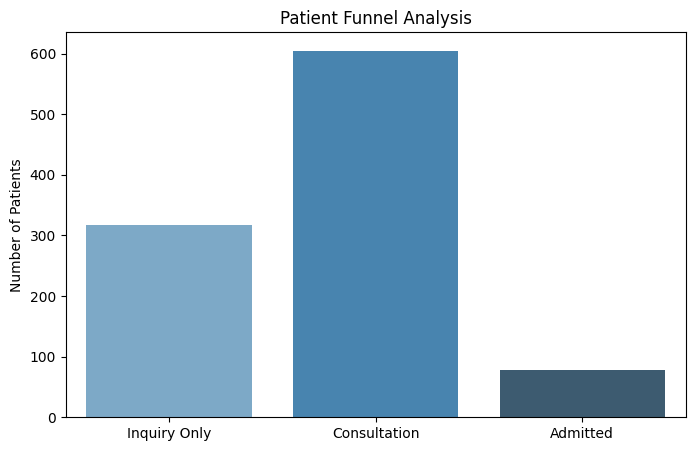

/tmp/ipython-input-1539146074.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=drop_reasons.values, y=drop_reasons.index, palette='Reds_r')


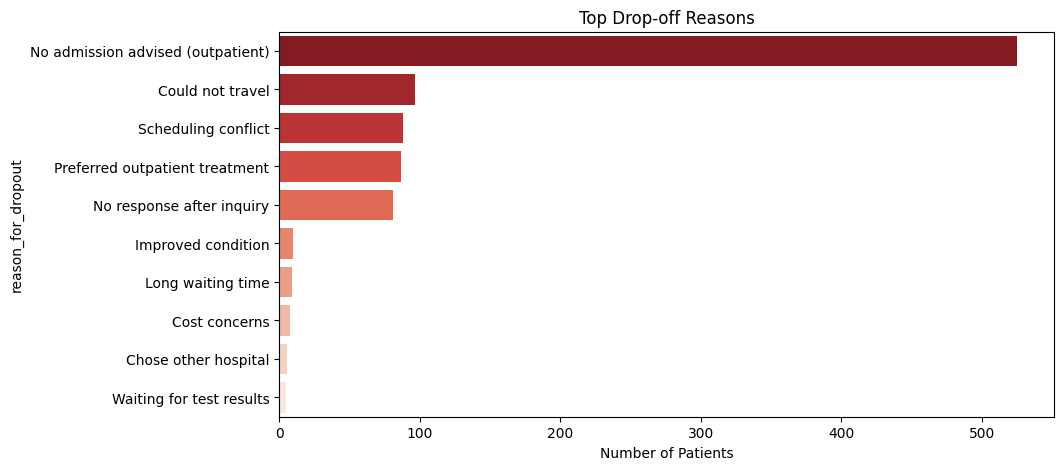

In [ ]:
stage_counts = df['funnel_stage'].value_counts().sort_index()
stage_labels = ['Inquiry Only','Consultation','Admitted']

plt.figure(figsize=(8,5))
sns.barplot(x=stage_labels, y=stage_counts.values, palette='Blues_d')
plt.title('Patient Funnel Analysis')
plt.ylabel('Number of Patients')
plt.show()

# Drop-off reasons analysis
drop_reasons = df[df['funnel_stage']<2]['reason_for_dropout'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=drop_reasons.values, y=drop_reasons.index, palette='Reds_r')
plt.title('Top Drop-off Reasons')
plt.xlabel('Number of Patients')
plt.show()

### **Channel-wise Conversion**

/tmp/ipython-input-1905027918.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_conversion.index, y=channel_conversion.values, palette='Greens_d')


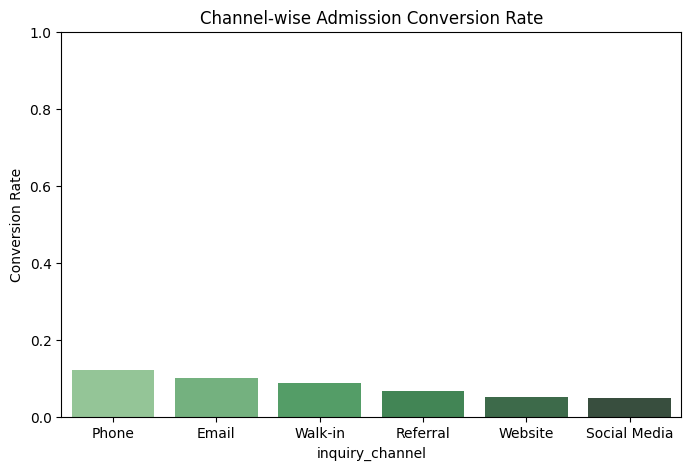

In [ ]:
channel_conversion = df.groupby('inquiry_channel')['admitted'].apply(lambda x: (x=='Yes').mean()).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=channel_conversion.index, y=channel_conversion.values, palette='Greens_d')
plt.title('Channel-wise Admission Conversion Rate')
plt.ylabel('Conversion Rate')
plt.ylim(0,1)
plt.show()

### **ML-based Dropout Prediction**

In [ ]:
# Encode categorical variables
cat_cols = ['inquiry_channel','disease_type','doctor_assigned','gender','insurance','referral_source']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [ ]:
# Features & Target
features = ['inquiry_channel','disease_type','doctor_assigned','age','gender','insurance','followup_attempts','response_time_days','referral_source']
target = 'admitted'
df[target] = df[target].map({'Yes':1,'No':0})

X = df[features]
y = df[target]

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Model training
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
# Model evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       184
           1       0.00      0.00      0.00        16

    accuracy                           0.92       200
   macro avg       0.46      0.50      0.48       200
weighted avg       0.85      0.92      0.88       200


Confusion Matrix:
 [[184   0]
 [ 16   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipython-input-1075898782.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


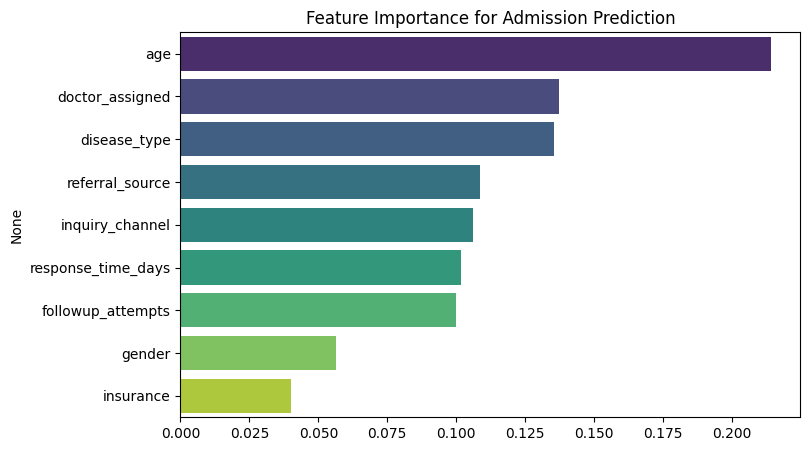

In [ ]:
# Feature Importance
feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Feature Importance for Admission Prediction')
plt.show()


### **Insights & Recommendations**

In [ ]:
print("\n--- Insights & Recommendations ---")
print("1. Top drop-off reasons should be targeted with follow-ups or communication improvements.")
print("2. Channels like {} have highest admission rates — prioritize these for marketing and inquiries.".format(channel_conversion.index[0]))
print("3. Age, insurance, follow-up attempts, and response time are important factors in predicting admissions.")
print("4. Doctors with low conversion rates may require process review or patient engagement improvements.")
print("5. Use the ML model to prioritize high-risk patients for follow-up to increase overall conversion.")



--- Insights & Recommendations ---
1. Top drop-off reasons should be targeted with follow-ups or communication improvements.
2. Channels like Phone have highest admission rates — prioritize these for marketing and inquiries.
3. Age, insurance, follow-up attempts, and response time are important factors in predicting admissions.
4. Doctors with low conversion rates may require process review or patient engagement improvements.
5. Use the ML model to prioritize high-risk patients for follow-up to increase overall conversion.
